In [1]:
import numpy as np

# pandas and geopandas packages
import pandas as pd
from geopandas import gpd

# cartoframes visualization tools
from cartoframes.viz import (Map, Layer, color_continuous_style, color_continuous_legend,
                            color_category_style, basic_legend, basic_style)

# import chart visualization libraries
import plotnine.options as ggplot_options
from plotnine import ggplot, aes, ggtitle, geom_bar, coord_flip, scale_fill_manual 

from utilities.aggregation_utilities import get_popular_stations
from utilities.spatial_data_utilities import get_nyc_census_tracts

import warnings

warnings.filterwarnings("ignore")

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# load our datasets
nyctracts_df = get_nyc_census_tracts()
bikes_df = pd.read_csv("../data/processed/bikes_2016_02.csv")

# cast dates to correct types
bikes_df['starttime'] = pd.to_datetime(bikes_df['starttime'])
bikes_df['stoptime'] = pd.to_datetime(bikes_df['stoptime'])

# turn our bikes pandas dataframe to a geopandas dataframe
bikes_gdf = gpd.GeoDataFrame(
    bikes_df,
    geometry=gpd.points_from_xy(
        bikes_df['end station longitude'],
        bikes_df['end station latitude']
    )
)

bikes_gdf.head(2)

,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,...,month,day,start_hour,start_minute,stop_hour,stop_minute,age,tripduration_minutes,tripduration_hours,geometry
0,0,461,2016-02-01 00:00:08,2016-02-01 00:07:49,480,W 53 St & 10 Ave,40.766697,-73.990617,524,W 43 St & 6 Ave,...,2,1,0,0,0,7,50.0,7.683333,0.128056,POINT (-73.98317 40.75527)
1,1,297,2016-02-01 00:00:56,2016-02-01 00:05:53,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,...,2,1,0,0,0,5,39.0,4.950000,0.082500,POINT (-74.00294 40.73401)


### Exploring popular start and end stations

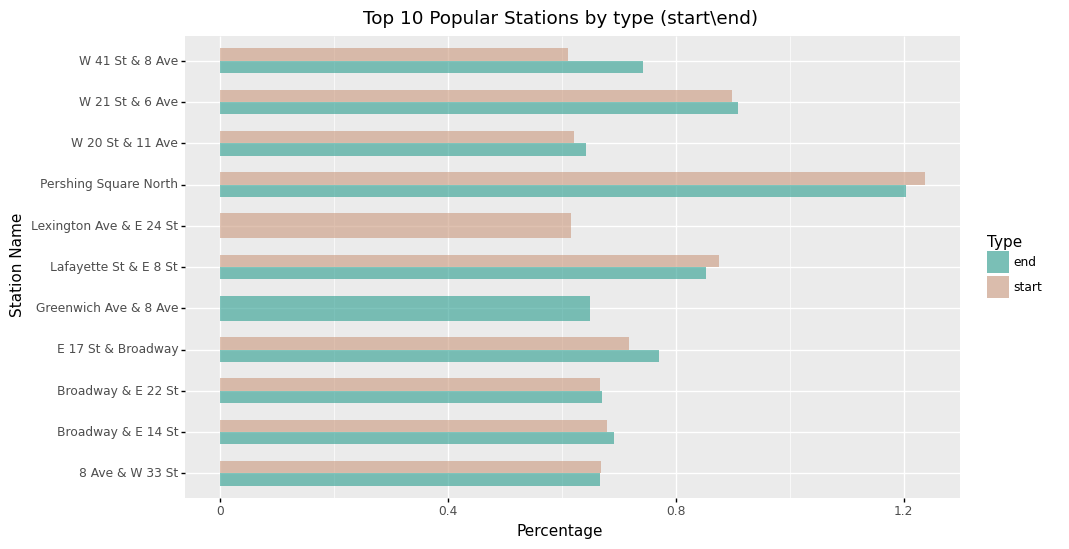

<ggplot: (348449287)>

In [3]:
ggplot_options.figure_size = (10, 6)

# get popular start stations
(get_popular_stations(bikes_df, type='start')
# append the popular end stations
.append(get_popular_stations(bikes_df, type='end'))
.pipe(ggplot) +
    aes(x='Station Name', y='Percentage', fill='Type') +
    geom_bar(stat='identity', alpha=0.6, width=0.6, position='dodge') +
    coord_flip() +
    ggtitle("Top 10 Popular Stations by type (start\\end)") +
    scale_fill_manual(values=["#2a9d8f", "#cb997e"])
)

We can see that the most popular start stations are "Pershing Square North", "21st St and 6th Avenue" and "Lafayette St & E 8 St". Those are the most popular end stations as well. We can also observe that Lexington Avenue is mostly used as a starting location, while Greenwich Avenue is mostly used for an ending location. One thing to keep in mind is that this might be due to a greater number of bikes available at those stations.

### **Visualizing bikers by different neighbourhoods**

Let's explore our bikers, joining with a dataset containing information about administrative units such as neighbourhoods. That way we can explore different relationships between the bikership data and different statistics like population size and median income.

In [4]:
nyctracts_df["county_fips"] = nyctracts_df.geoid.str[:5]
Map([
      Layer(
            nyctracts_df, 
            style=color_continuous_style('total_pop_2011_2015'),
            legends=color_continuous_legend(title="Total population size in neighbourhood")
      ),
      Layer(
            bikes_gdf.sample(4000),
            style=color_category_style(
                  'gender',
                  palette="[#335599, #cb997e, #ca6702]",
            ),
            legends=basic_legend(title="Different bike user", description="The observations are taken from a sample with size 4000")
      )
])

From the visualization above we can see that the start stations are mostly situated in the central part of New York City.

Another thing we can explore spationally is bikers according to different time intervals, like before or after noon.

### **Bikers according to rush hours**

In [5]:
MORNING_HOURS = [5, 6, 7, 8, 9]
EVENING_HOURS = [16, 17, 18, 19]

# filter rush hour rides only
rush_hours_bikes_gdf = bikes_gdf[bikes_gdf['start_hour'].isin(MORNING_HOURS + EVENING_HOURS)]

# attach different hour type according to morning or evening
morning_mask = rush_hours_bikes_gdf['start_hour'].isin(MORNING_HOURS)
rush_hours_bikes_gdf['Hour Type'] = np.where(morning_mask, "05-09", "16-19")

Map([
      Layer(nyctracts_df, style=basic_style(color="#336699", opacity=0.5)),
      Layer(
            rush_hours_bikes_gdf.sample(4000, random_state=1),
            style=color_category_style(
                  "Hour Type",
                  palette="[#335599, #cb997e]",
            ),
            legends=basic_legend(
                  title="Bike users by rush hour type",
                  description="The observations are taken from a sample with size 4000"
            )
      )
])

We see that there are places with more clustered rides starting in the morning hour and places with more clustered riders starting at the evening rush hours. Another thing we can visualize is different neighbourhoods with more intensive color by number of bikers.

### **Neighbourhoods by bikers count**

In [6]:
BIKERS_VIZ_SAMPLE_SIZE = 40000

bikers_count_by_neighbourhood_df = (gpd
 .sjoin(nyctracts_df, bikes_gdf.sample(BIKERS_VIZ_SAMPLE_SIZE))
 .dissolve(by='geoid', aggfunc='count')
 .rename(columns={'gender': 'Bikers Count'})
)

Map(
    Layer(bikers_count_by_neighbourhood_df,
        style=color_continuous_style('Bikers Count', opacity=0.7),
        legends=color_continuous_legend(
            title="Number of bikers in a neighbourhood",
            description=f"The number of bikers is taken from a sample of {BIKERS_VIZ_SAMPLE_SIZE}"
        )
    ),
    show_info=True
)

In the above visualization we see that there is a lot higher number of bikers in the central part of New York City, while the outer parts are not having such popularity.

### **Neighbourhoods by mean age of bikers**

In [7]:
BIKERS_VIZ_SAMPLE_SIZE = 40000

bikers_mean_by_neighbourhood_df = (gpd
 .sjoin(nyctracts_df, bikes_gdf.sample(BIKERS_VIZ_SAMPLE_SIZE))
 .dissolve(by='geoid', aggfunc='mean')
)

Map(
    Layer(bikers_mean_by_neighbourhood_df,
        style=color_continuous_style('age', opacity=0.7),
        legends=color_continuous_legend(
            title="Mean age of bikers by different neighbourhoods",
            description=f"The visualization is constructed on a sample of {BIKERS_VIZ_SAMPLE_SIZE}"
        )
    ),
    show_info=True
)

We can see that in the eastern part of the City of New York, the mean age is a lot lower, while in the north-western part the mean age is sometimes above 45.